In [40]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import hdbscan
import nltk
import spacy

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

spaci = spacy.load("en_core_web_sm")

In [41]:
df = pd.read_csv('hsbc_comments.csv')
df.head()

,message
0,I would like to say a massive thank you to HSB...
1,"""Imaginations Run Wild?"" my backside- try gett..."
2,If you would send me the neccesary number I wo...
3,"Just past 1 hour waiting again, for the 3rd ti..."
4,Melanie Humberstone


In [42]:
df.message.replace("_" , " ", regex=True, inplace = True)
df.message.replace("^" , " ", regex=True, inplace = True)

In [43]:
df.message.head()

0     I would like to say a massive thank you to HS...
1     "Imaginations Run Wild?" my backside- try get...
2     If you would send me the neccesary number I w...
3     Just past 1 hour waiting again, for the 3rd t...
4                                  Melanie Humberstone
Name: message, dtype: object

In [44]:
import string
for punc in string.punctuation:
    if punc == "@": pass
    elif punc == "'":
        df.message.replace(f"\{punc}", " ", regex=True, inplace = True)
    else:
        try:
            df.message.replace(f"\{punc}", "", regex=True, inplace = True)
        except:
            pass

In [45]:
df.message[0]

' I would like to say a massive thank you to HSBC and the telephone staff Someone was using my card and you help me thorough the process of stopping it immediately You were friendly and efficient I will always bank HSBC '

In [46]:
junk_words = "tqvm yessssssssssit youuuuuu nan nt citi kashif a very were yet than through via here rishisunak more much getting go going ive dont able when which who year barclays hsbcin amp like an no any since after banking im there out how starlingbank starling one only again over other then am may some do cant about banks would could its even their after has them get got within now all just if what or at had hsbcukbusiness up by into will an was our us so been hsbcuk co om ke ha gone your we can from as but to the hsbc and of you for are have they is my hsbc_uk with it in on this ðÿ be not bank me that"
junk_words_list = junk_words.split(" ")

In [47]:
def remove_unicode(text):

    try:
        text = text.encode("latin_1").decode("raw_unicode_escape").encode('utf-16', 'surrogatepass').decode('utf-16')
    except:
        text = text

    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)

    text = re.sub(emoji_pattern, '', str(text))
    text = ''.join(text.split('\\n')) # to remove uncompiled \n
    text = re.sub('\n', '', text)     # to remove compiled \n

    return text

In [48]:
def clean_data(text, small_word_lmt=2, extra_words=junk_words_list):
    list_data2=[]
    text = remove_unicode(text)
    sentence=text.lower().split(' ')
    for word in sentence:
        if word == "hi":
            word = word.replace("hi", "hello")
        
        if word.startswith("@"):
            list_data2.append(word)
        elif not word.startswith('http') \
           and word.isalpha() \
           and len(word)>small_word_lmt \
           and word not in extra_words:
            list_data2.append(word)
    return " ".join(list_data2)
df.message = df.message.apply(lambda x: clean_data(x))

In [49]:
df.message[0]

'say massive thank telephone staff someone using card help thorough process stopping immediately friendly efficient always'

In [50]:
def word_root(text):
    list_data3=[]
    
    doc = spaci(text)
    for token in doc:
        lemma = token.lemma_
        if lemma != "do":
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)
df.message = df.message.apply(lambda x: word_root(x))  

In [51]:
df.message[0]

'say massive thank telephone staff someone use card help thorough process stop immediately friendly efficient always'

In [52]:
# adjustment for non-english words

# nltk.download('words')
# eng_words = set(nltk.corpus.words.words())
# df["eng"] = df.message.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i in eng_words]))
# df["noneng"] = df.message.apply(lambda x: " ".join([i for i in nltk.wordpunct_tokenize(x) if i not in eng_words]))
# df.noneng.tolist()

In [53]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([message.split() for message in df.message])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [54]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([message.split() for message in df.message])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(20)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [55]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [56]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [57]:
bigrams = [' '.join(x) for x in bigram_pmi.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in trigram_pmi.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [58]:
bigrams

['can not',
 'inbox inbox',
 'cut off',
 'credit card',
 'local branch',
 'bounce back',
 'back loan',
 'spend hour',
 'put hold',
 'customer service',
 'bad service',
 'still wait',
 'answer phone',
 'close account',
 'open account',
 'someone call',
 'business account',
 'hold hour',
 'hour hold',
 'call back',
 'hour phone']

In [59]:
trigrams

['inbox inbox inbox', 'bounce back loan']

In [60]:
replace_ngrams = {"bounce back loan":"bounce_back_loan", "cut off":"cut_off",
                  "credit card":"credit_card",'local branch':"local_branch",
                  "bounce back":"bounce_back",'customer service':'customer_service',
                  'back loan':'back_loan', 'still wait':'still_wait',"spend hour":"spend_hour",
                 "put hold":"put_hold","bad service":"bad_service","answer phone":"answer_phone",
                 "close account":"close_account","open account":"open_account","someone call":"someone_call",
                 "business account":"business_account","hold hour":"hold_hour","hour hold":"hour_hold",
                 "call back":"call_back","hour phone":"hour_phone"}
for key, value in replace_ngrams.items():
    df.message.replace(f"\S*{key}\S*" , f"{value} "*3, regex=True, inplace = True)
    

In [61]:
# replace_key_words = ['delay', 'wait', 'on_hold', 'any_news', 'awful', 'disappointed', 'give_up', 'regret', 'worse', 'worst', 'unhappy', 'sucksunbelievable', 'frustrated', 'disgusted', 'happy', 'disgrace', 'awesome', 'fantastic', 'well_done', 'great', 'leave', 'bye', 'switch', 'covidenvironment', 'fossil', 'coal', 'fuel', 'climate', 'carbon', 'best', 'wonderfull']
# for key_word in replace_key_words:
#     df.message.replace(f"\S*{key_word}\S*" , f"{key_word} "*2, regex=True, inplace = True)


In [62]:
# df.drop(df[df.message.str.contains("tatacrucible")].index, axis=0,inplace=True)

In [63]:
df_clean = df.message
df_clean.shape

(990,)

In [64]:
df_clean = df_clean.dropna()
df_clean.shape

(990,)

In [65]:
list_data = df_clean.to_list()
list_data = [str(sent) for sent in list_data]

In [66]:
from sentence_transformers import SentenceTransformer

In [67]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1

In [68]:
model=SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings1 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

In [69]:
# embeddings1[embeddings1.argmax()]

In [70]:
model=SentenceTransformer('paraphrase-distilroberta-base-v1')
embeddings2 = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/31 [00:00<?, ?it/s]

In [71]:
embeddings1_norm = embeddings1 /  np.linalg.norm(embeddings1, axis=1, keepdims=True)
embeddings2_norm = embeddings2 /  np.linalg.norm(embeddings2, axis=1, keepdims=True)

In [72]:
import umap

In [73]:
from sklearn.decomposition import PCA 
from sklearn.manifold import TSNE

In [74]:
UMAP_bert1 = umap.UMAP(n_components=2).fit_transform(embeddings1)
UMAP_bert1_norm = umap.UMAP(n_components=2).fit_transform(embeddings1_norm)

UMAP_bert2 = umap.UMAP(n_components=2).fit_transform(embeddings2)
UMAP_bert2_norm = umap.UMAP(n_components=2).fit_transform(embeddings2_norm)

#n_neighbors=10, min_dist=0.0, 

In [75]:
PCA_bert1 = PCA(n_components=2).fit_transform(embeddings1)
PCA_bert1_norm = PCA(n_components=2).fit_transform(embeddings1_norm)

PCA_bert2 = PCA(n_components=2).fit_transform(embeddings2)
PCA_bert2_norm = PCA(n_components=2).fit_transform(embeddings2_norm)

In [76]:
tSNE_bert1 = TSNE(n_components=2).fit_transform(embeddings1)
tSNE_bert1_norm = TSNE(n_components=2).fit_transform(embeddings1_norm)

tSNE_bert2 = TSNE(n_components=2).fit_transform(embeddings2)
tSNE_bert2_norm = TSNE(n_components=2).fit_transform(embeddings2_norm)

In [77]:
from pyclustertend import hopkins
hopkins(UMAP_bert2,UMAP_bert2.shape[0])

0.03958020072381353

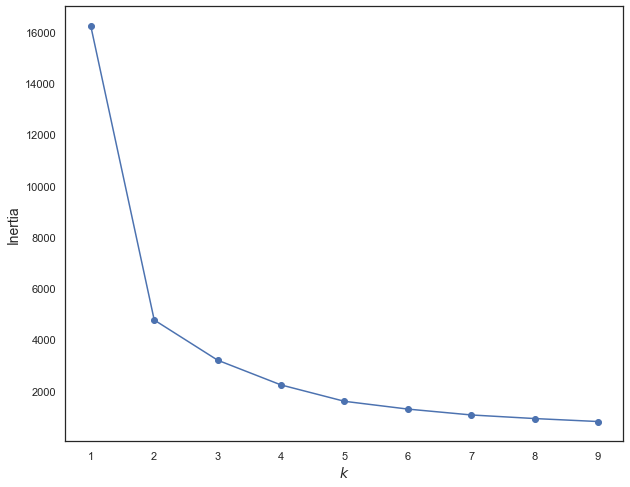

In [78]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(UMAP_bert2)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [79]:
def cluster_results(Kmeans_clusters=4):
    
    ClusterDict = {}
    dim_embeddings = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                      "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                      "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                      "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                      "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                      "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm}
    
    for key, val in dim_embeddings.items():
        ClusterDict[key] = KMeans(n_clusters=Kmeans_clusters).fit_predict(val)
        ClusterDict[key+"_hdbscan"] = hdbscan.HDBSCAN(min_samples = 30,
                           min_cluster_size=15,
                           metric = 'euclidean',
                           cluster_selection_epsilon = 0.25,
                           cluster_selection_method = "eom").fit_predict(val)
    return ClusterDict

In [80]:
clustering_result = cluster_results()

In [81]:
def plot(cluster = clustering_result):    
    reduced_dims = {"UMAP_bert1" : UMAP_bert1, "UMAP_bert1_norm" : UMAP_bert1_norm, 
                    "UMAP_bert2" : UMAP_bert2, "UMAP_bert2_norm" : UMAP_bert2_norm,
                    "PCA_bert1" : PCA_bert1, "PCA_bert1_norm" : PCA_bert1_norm, 
                    "PCA_bert2" : PCA_bert2, "PCA_bert2_norm" : PCA_bert2_norm,
                    "tSNE_bert1" : tSNE_bert1, "tSNE_bert1_norm" :  tSNE_bert1_norm, 
                    "tSNE_bert2" : tSNE_bert2, "tSNE_bert2_norm" : tSNE_bert2_norm,
                    "UMAP_bert1_hdbscan" : UMAP_bert1, "UMAP_bert1_norm_hdbscan" : UMAP_bert1_norm, 
                    "UMAP_bert2_hdbscan" : UMAP_bert2, "UMAP_bert2_norm_hdbscan" : UMAP_bert2_norm,
                    "PCA_bert1_hdbscan" : PCA_bert1, "PCA_bert1_norm_hdbscan" : PCA_bert1_norm, 
                    "PCA_bert2_hdbscan" : PCA_bert2, "PCA_bert2_norm_hdbscan" : PCA_bert2_norm,
                    "tSNE_bert1_hdbscan" : tSNE_bert1, "tSNE_bert1_norm_hdbscan" :  tSNE_bert1_norm, 
                    "tSNE_bert2_hdbscan" : tSNE_bert2, "tSNE_bert2_norm_hdbscan" : tSNE_bert2_norm}

    for clustee_name, clustee in cluster.items():
        clustered = (clustee >= 0)
        reduced_dim = reduced_dims[clustee_name]
            
        print(f"----------{clustee_name}--------------------")

        unique, counts = np.unique(clustee, return_counts=True)
        print(dict(zip(unique, counts)))

        plt.scatter(reduced_dim[~clustered, 0],
                    reduced_dim[~clustered, 1],
                    c=(0.5,0.5,0.5),
                    # s=1,
                    alpha=0.5
                    )
        plt.scatter(reduced_dim[clustered, 0],
                    reduced_dim[clustered, 1],
                    c=clustee[clustered],
                    # s=1,
                    cmap='Spectral')
        plt.show()

----------UMAP_bert1--------------------
{0: 158, 1: 237, 2: 318, 3: 277}


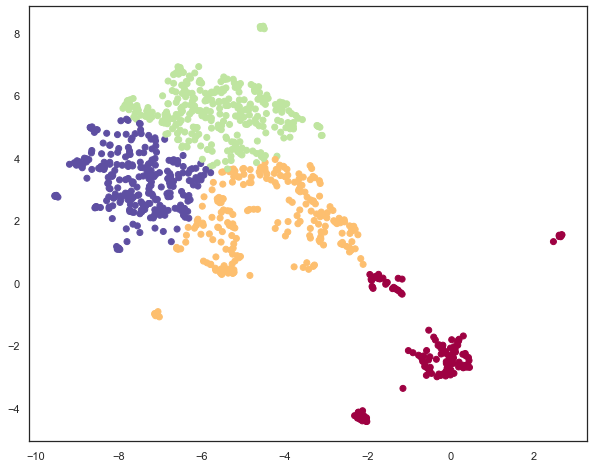

----------UMAP_bert1_hdbscan--------------------
{-1: 76, 0: 88, 1: 826}


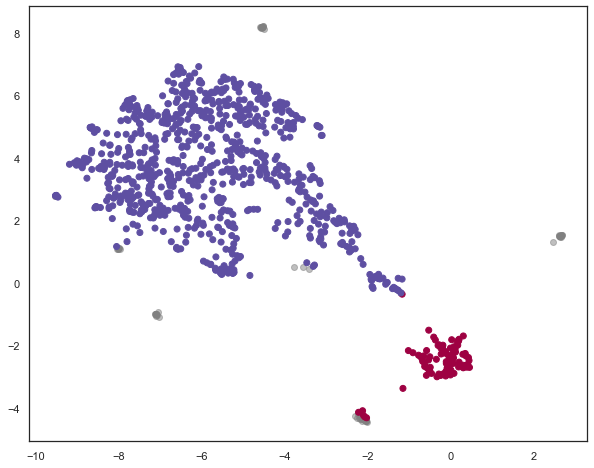

----------UMAP_bert1_norm--------------------
{0: 316, 1: 162, 2: 216, 3: 296}


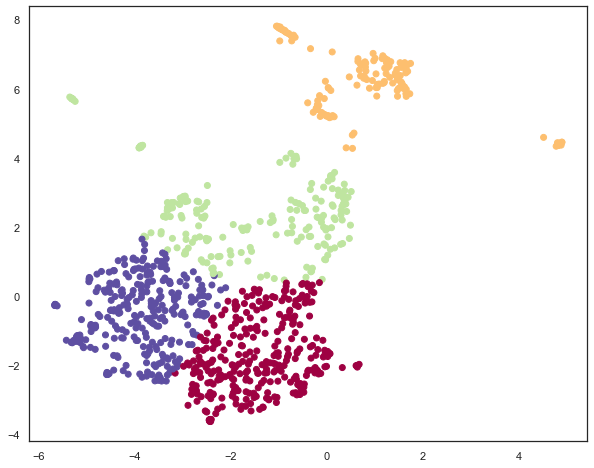

----------UMAP_bert1_norm_hdbscan--------------------
{-1: 67, 0: 126, 1: 797}


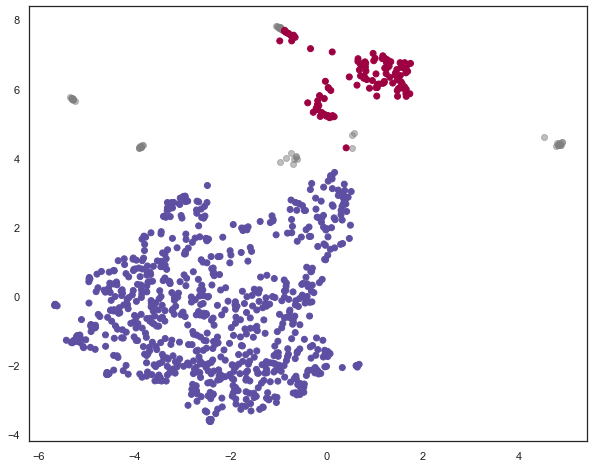

----------UMAP_bert2--------------------
{0: 252, 1: 128, 2: 351, 3: 259}


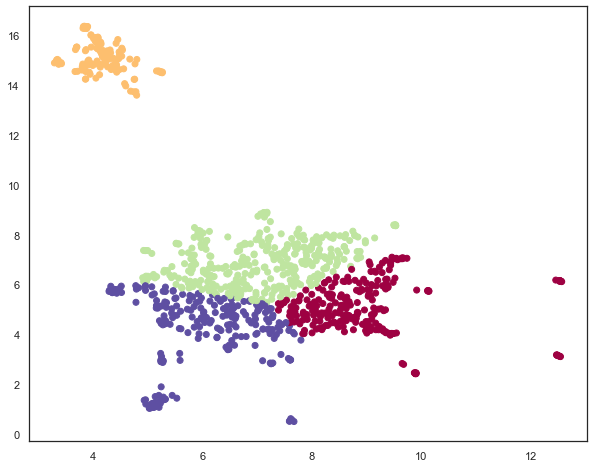

----------UMAP_bert2_hdbscan--------------------
{-1: 66, 0: 128, 1: 35, 2: 761}


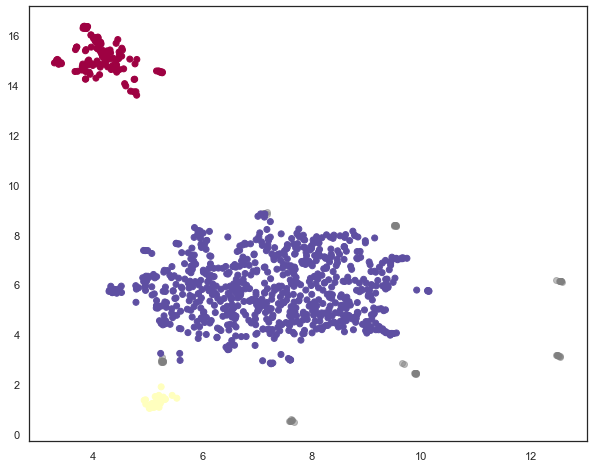

----------UMAP_bert2_norm--------------------
{0: 258, 1: 122, 2: 260, 3: 350}


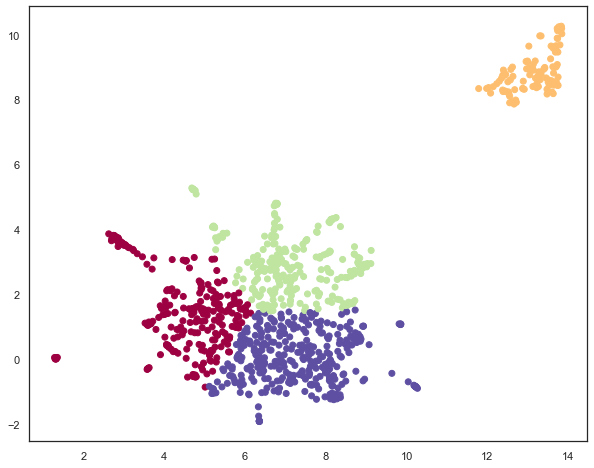

----------UMAP_bert2_norm_hdbscan--------------------
{0: 122, 1: 868}


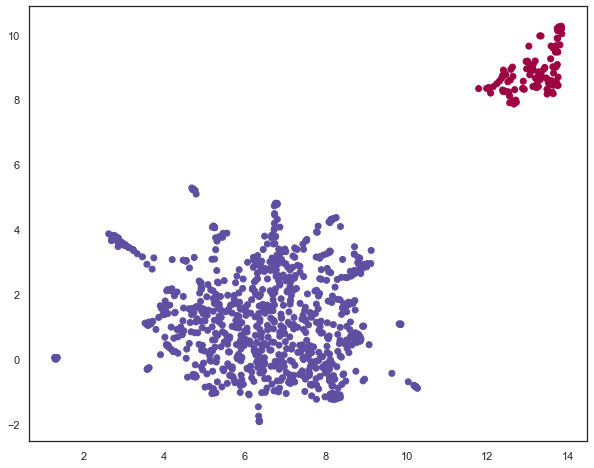

----------PCA_bert1--------------------
{0: 263, 1: 177, 2: 346, 3: 204}


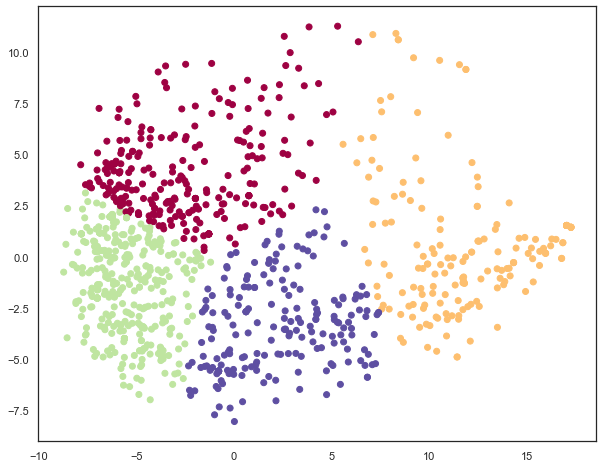

----------PCA_bert1_hdbscan--------------------
{-1: 429, 0: 27, 1: 23, 2: 37, 3: 38, 4: 436}


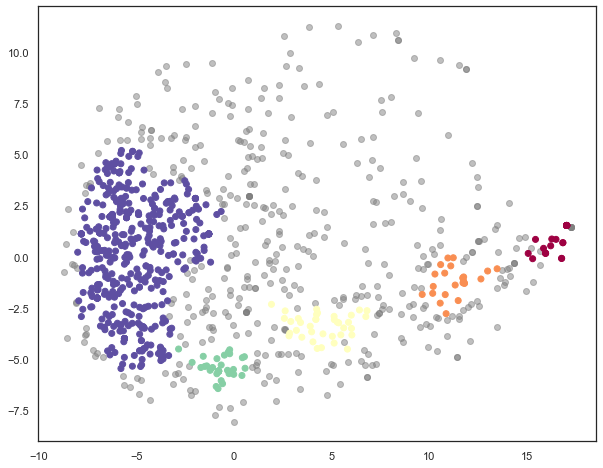

----------PCA_bert1_norm--------------------
{0: 341, 1: 182, 2: 268, 3: 199}


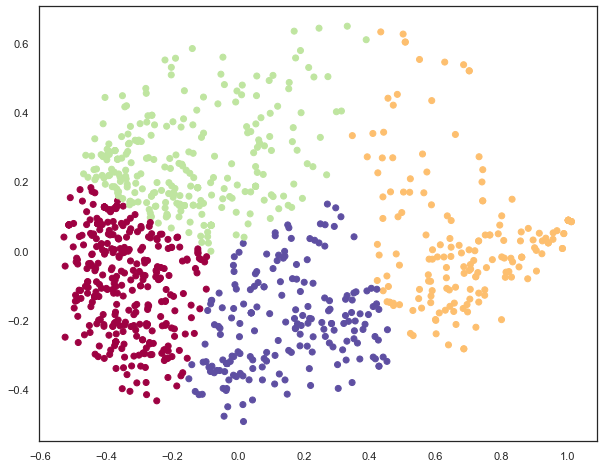

----------PCA_bert1_norm_hdbscan--------------------
{-1: 292, 0: 143, 1: 555}


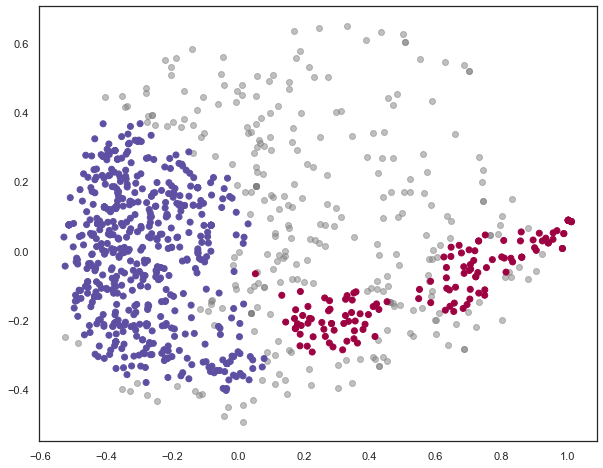

----------PCA_bert2--------------------
{0: 138, 1: 428, 2: 401, 3: 23}


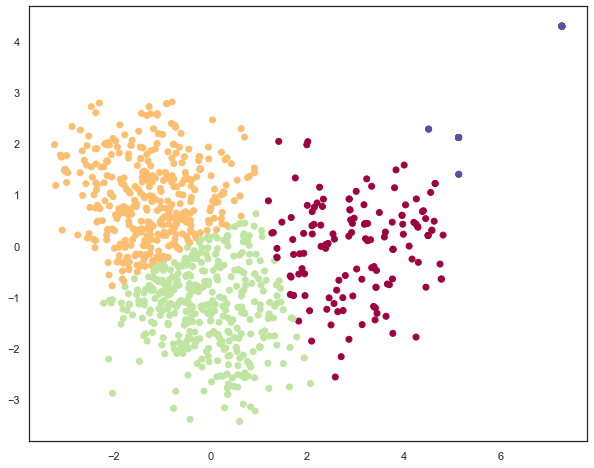

----------PCA_bert2_hdbscan--------------------
{-1: 816, 0: 19, 1: 155}


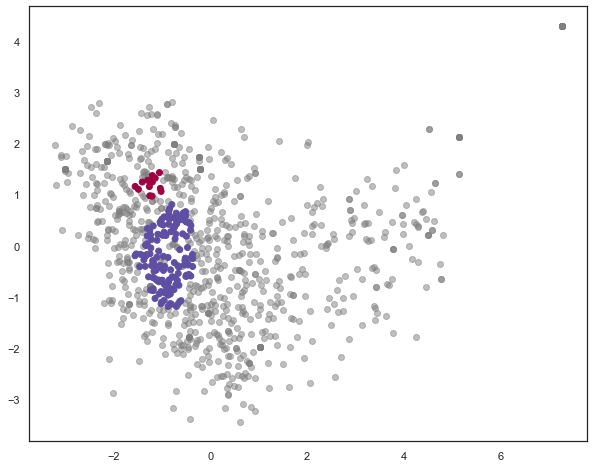

----------PCA_bert2_norm--------------------
{0: 357, 1: 222, 2: 128, 3: 283}


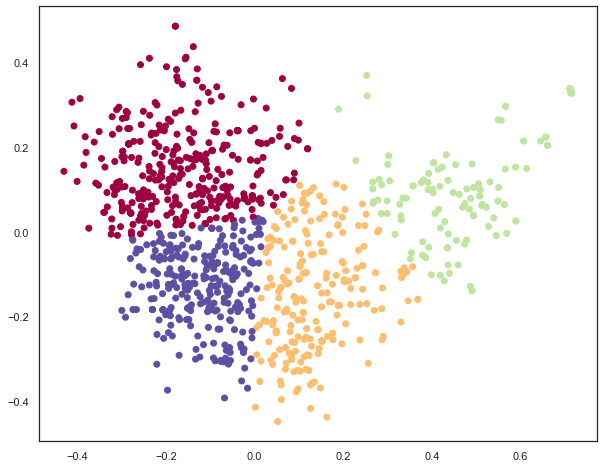

----------PCA_bert2_norm_hdbscan--------------------
{-1: 171, 0: 40, 1: 779}


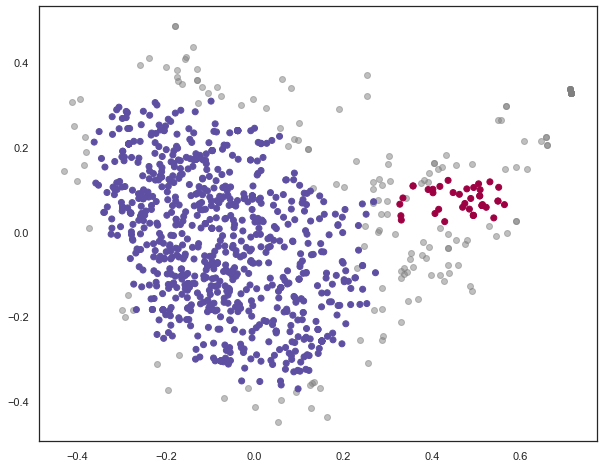

----------tSNE_bert1--------------------
{0: 236, 1: 303, 2: 277, 3: 174}


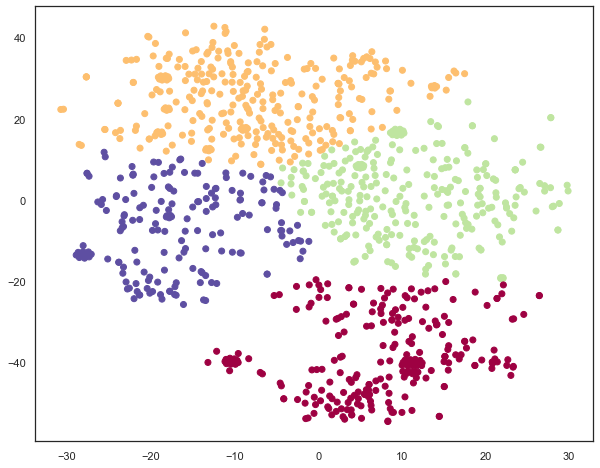

----------tSNE_bert1_hdbscan--------------------
{-1: 142, 0: 183, 1: 665}


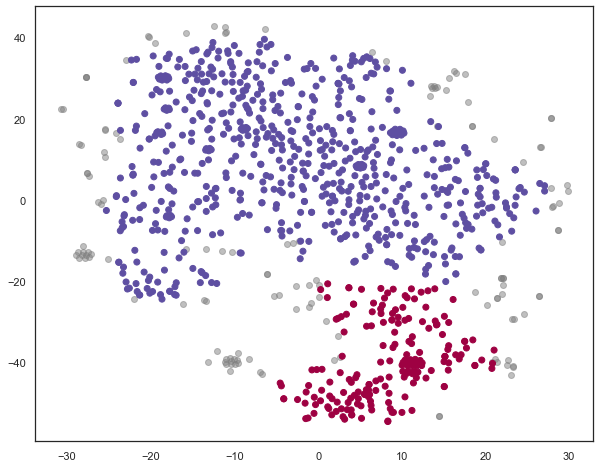

----------tSNE_bert1_norm--------------------
{0: 271, 1: 204, 2: 257, 3: 258}


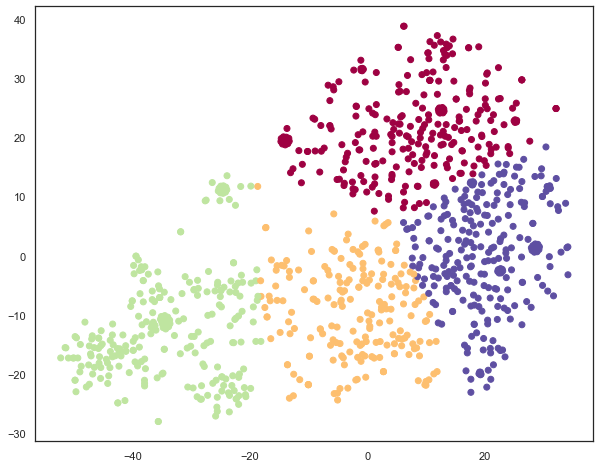

----------tSNE_bert1_norm_hdbscan--------------------
{-1: 328, 0: 508, 1: 138, 2: 16}


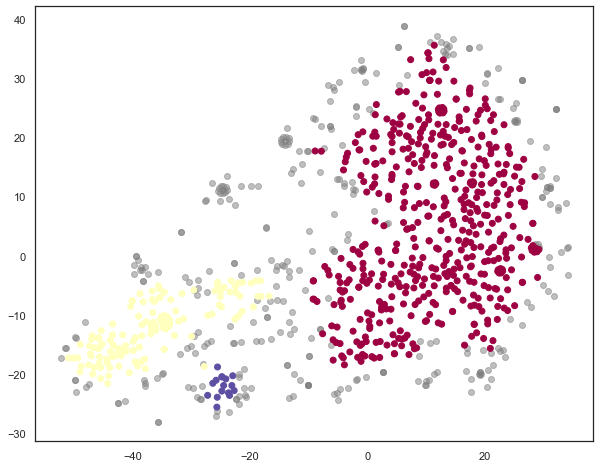

----------tSNE_bert2--------------------
{0: 180, 1: 240, 2: 285, 3: 285}


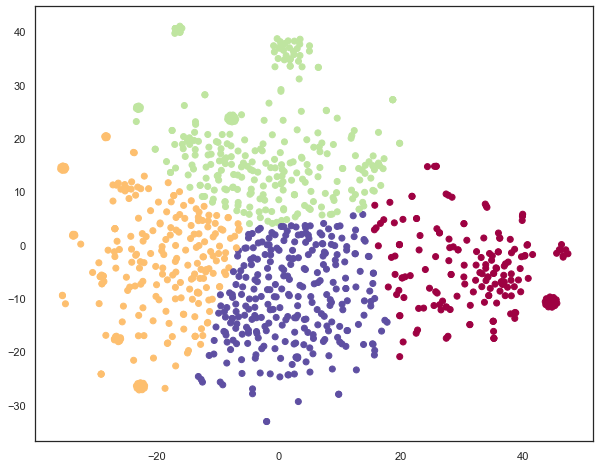

----------tSNE_bert2_hdbscan--------------------
{-1: 285, 0: 32, 1: 598, 2: 75}


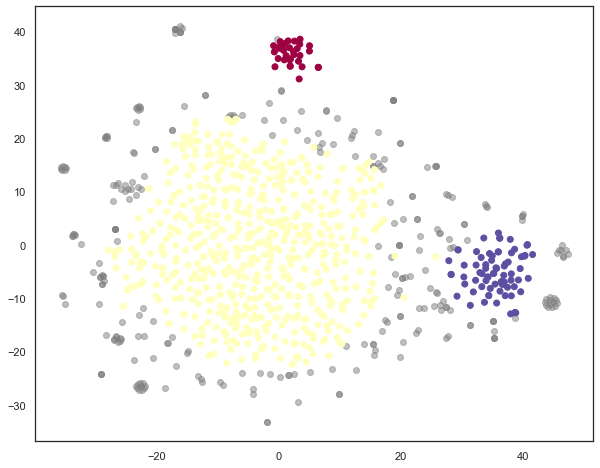

----------tSNE_bert2_norm--------------------
{0: 225, 1: 318, 2: 289, 3: 158}


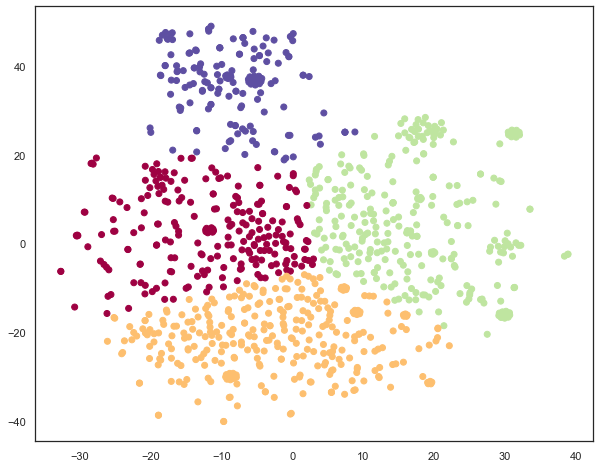

----------tSNE_bert2_norm_hdbscan--------------------
{-1: 266, 0: 120, 1: 32, 2: 572}


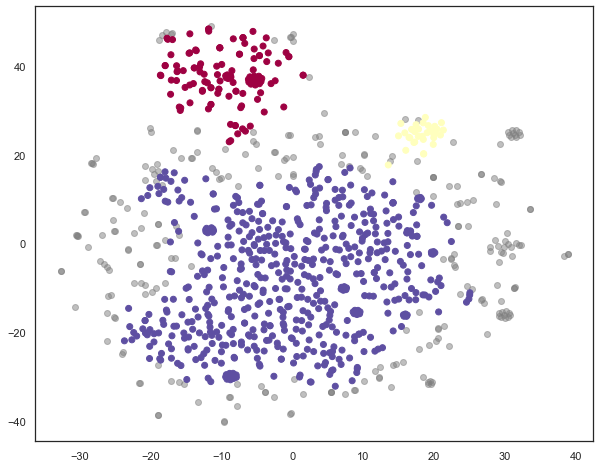

In [82]:
plot()

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidfmatrix(data, vectorizer):
    terms = vectorizer.fit_transform(data)
    return pd.DataFrame(terms.toarray(), columns = vectorizer.get_feature_names())

In [84]:
def cluster_words(clustering_result=clustering_result, top_n = 20):
    for name, value in clustering_result.items():
        print(f"===================================={name}=============================================")
    
        #creatin new df in order to groupby same clusters
        cluster = value
        docs = pd.DataFrame(df_clean)
        docs["cluster"] = cluster

        labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"message": " ".join})
                
        tfidf_vec = TfidfVectorizer(max_df=.8)
        try:
            tfidf_mat = tfidfmatrix(labeled_docs.message, tfidf_vec)
        except: pass
        
        global most_common
        most_common = pd.DataFrame({n: tfidf_mat.T[col].nlargest(top_n).index.tolist() 
                                for n, col in enumerate(tfidf_mat.T)}).T
#         most_common.index = np.unique(cluster)
        display(most_common)

In [85]:
cluster_words()

====================================UMAP_bert1=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,earn,neil,cool,datethat,goodnew,introduce,mende,sharing,shawn,tooclick,chima,benefit,brilliant,amazing,iawn,lovely,chi,kwabena,proud,awesome
1,inbox,customer_service,answer_phone,bad_service,message,reply,call_back,email,access,receive,send,problemnnstaff,ask,business,cut_off,number,useless,online,still,clue
2,hour_hold,put_hold,try,customer_service,spend_hour,time,hour,business_account,hold,cut_off,take,minute,week,someone_call,day,business,still,online,still_wait,month
3,customer_service,close_account,business_account,pension,try,take,time,bad_service,people,local_branch,open_account,pay,month,answer_phone,send,year,bad,be,branch,business


====================================UMAP_bert1_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bad_service,put_hold,two,company,hold,minute,earn,close_account,call,agonnhsbc,artist,bankingnngot,con,cool,datethat,goodnew,introduce,mende,phonenntime,problemnnstaff
1,neil,brilliant,amazing,hope,love,proud,chima,job,awesome,being,nation,colleague,human,achievement,colour,grateful,improvement,inspirational,russell,anyone
2,customer_service,business_account,hour_hold,try,cut_off,call,money,hour,time,take,week,day,send,online,answer_phone,people,customer,local_branch,wait,business


====================================UMAP_bert1_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,hour_hold,customer_service,try,phone,business_account,time,hour,someone_call,spend_hour,take,online,week,still,hold,day,answer,cut_off,email,bounce_back_loan,business
1,earn,neil,cool,datethat,goodnew,introduce,mende,sharing,shawn,tooclick,chima,glad,because,benefit,brilliant,cash,home,link,till,amazing
2,bad_service,two,hold,put_hold,minute,inbox,customer_service,phone,close_account,answer_phone,business,useless,agonnhsbc,artist,bankingnngot,con,phonenntime,problemnnstaff,call_back,message
3,customer_service,phone,take,try,time,business_account,cut_off,pay,bad_service,local_branch,people,business,close_account,open_account,year,branch,minute,bounce_back_loan,send,because


====================================UMAP_bert1_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,two,bad_service,put_hold,hold,company,minute,earn,call,agonnhsbc,artist,bankingnngot,con,cool,datethat,goodnew,introduce,mende,phonenntime,problemnnstaff,sharing
1,neil,chima,brilliant,amazing,hope,love,iawn,chi,kwabena,proud,job,awesome,being,nation,colleague,human,local_branch,mark,work,achievement
2,customer_service,business_account,hour_hold,phone,try,cut_off,call,money,time,take,week,day,send,online,customer,answer_phone,people,back,hour,business


====================================UMAP_bert2=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,hour_hold,call,phone,put_hold,bounce_back_loan,answer_phone,cut_off,hold,minute,customer_service,try,hour,call_back,wait,business,answer,service,spend_hour,customer,hour_phone
1,neil,chima,amazing,brilliant,iawn,chi,kwabena,merry,proud,awesome,both,christmas,mark,achievement,ashleigh,hogia,inspirational,louise,okechukwu,colleague
2,customer_service,inbox,service,bad_service,customer,account,money,send,people,number,new,credit_card,phone,business,business_account,message,wait,email,take,local_branch
3,account,pension,take,money,try,close_account,business_account,make,open_account,phone,call,someone_call,day,cut_off,branch,hour,today,bad_service,month,week


====================================UMAP_bert2_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,someone_call,try,two,bad_service,put_hold,today,january,hold,transfer,business_account,close_account,team,account,minute,credit_card,egypt,service,take,send,company
1,neil,chima,amazing,brilliant,iawn,hope,chi,kwabena,merry,proud,good,job,awesome,both,christmas,help,colleague,mark,achievement,ashleigh
2,pension,clawback,state,own,budget,take,pay,deduction,lowest,wwwmidlandclawbackcampaigncouk,claw,pensioner,thing,year,think,fair,many,see,right,shame
3,customer_service,account,phone,hour_hold,cut_off,wait,call,business_account,money,local_branch,open_account,try,customer,service,hold,bounce_back_loan,answer_phone,call_back,minute,email


====================================UMAP_bert2_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,account,pension,money,close_account,take,make,try,month,because,send,clawback,customer,give,want,call,fraud,payment,phone,year,be
1,neil,chima,brilliant,amazing,iawn,chi,kwabena,merry,proud,awesome,christmas,mark,achievement,ashleigh,hogia,inspirational,louise,okechukwu,russell,colleague
2,customer_service,bad_service,inbox,bounce_back_loan,service,customer,credit_card,phone,business,people,account,money,still_wait,company,send,machine,wait,still,message,minute
3,hour_hold,phone,call,answer_phone,try,business_account,account,put_hold,hold,hour,cut_off,someone_call,minute,app,wait,week,business,service,take,open_account


====================================UMAP_bert2_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,neil,chima,iawn,chi,kwabena,merry,proud,awesome,achievement,ashleigh,hogia,inspirational,louise,okechukwu,russell,aah,adelle,almond,amateur,anjit
1,customer_service,account,phone,call,try,money,business_account,take,service,hour_hold,customer,cut_off,hold,business,hour,minute,make,wait,still,week


====================================PCA_bert1=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,customer_service,bad_service,answer_phone,hour_hold,money,people,never,pension,staff,bad,close_account,egypt,business,credit_card,month,team,pay,management,fix,have
1,neil,chima,iawn,amazing,chi,kwabena,proud,bad,never,review,under,mark,ashleigh,grateful,hogia,improvement,okechukwu,effort,wear,acc
2,customer_service,business_account,money,spend_hour,someone_call,cut_off,minute,put_hold,business,day,online,send,today,hour_hold,open_account,hour_phone,give,month,local_branch,staff
3,inbox,customer_service,hour_hold,earn,company,answer_phone,still_wait,send,cool,datethat,goodnew,introduce,mende,sharing,shawn,tooclick,link,contact,month,benefit


====================================PCA_bert1_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,customer_service,inbox,account,phone,help,time,customer,still,call_back,business,take,cut_off,hour,day,business_account,hour_hold,online,money,wait,answer_phone
1,brilliant,sio,chima,see,both,aah,aaron,abet,ability,abolutley,about,above,abroad,absolute,absolutely,absolutley,abta,abuse,abysmal,acc
2,kwabena,mark,neil,grateful,being,chima,effort,human,job,matter,beautiful,clark,creed,denomination,emma,gallacher,gent,gwych,hillhouse,super
3,still_wait,customer_service,call,help,need,phone,child,close_account,human,message,neil,campaignhsbcsbiutm,mediumadutm,sourcefacebookutm,answer_phone,customer,many,post,reply,someone
4,company,earn,hour_hold,cool,datethat,goodnew,introduce,mende,sharing,shawn,tooclick,link,why,benefit,because,while,cash,contact,direct,glad
5,account,customer_service,try,business_account,call,phone,cut_off,take,time,money,bad_service,day,back,hour_hold,local_branch,open_account,business,say,staff,two


====================================PCA_bert1_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,customer_service,business_account,money,spend_hour,someone_call,cut_off,minute,put_hold,business,day,online,send,today,hour_hold,open_account,hour_phone,month,give,staff,email
1,neil,chima,iawn,amazing,chi,kwabena,proud,bad,never,review,under,mark,ashleigh,grateful,hogia,improvement,okechukwu,colleague,effort,wear
2,customer_service,bad_service,money,answer_phone,hour_hold,people,never,pension,staff,bad,close_account,egypt,business,credit_card,month,pay,team,management,due,fix
3,inbox,customer_service,hour_hold,earn,company,answer_phone,still_wait,send,cool,datethat,goodnew,introduce,mende,sharing,shawn,tooclick,link,contact,month,benefit


====================================PCA_bert1_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,call_back,hour_hold,time,useless,cut_off,bad,app,local_branch,chat,branch,give,business_account,credit_card,day,number,online,open_account,down,fraud,min
1,inbox,neil,chima,human,awesome,being,chi,iawn,kwabena,mark,post,achievement,campaignhsbcsbiutm,center,colour,grateful,inspirational,mediumadutm,private,sourcefacebookutm
2,business_account,time,hour_hold,cut_off,day,online,spend_hour,bad_service,someone_call,open_account,branch,local_branch,because,two,bounce_back_loan,number,put_hold,give,pay,credit_card


====================================PCA_bert2=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,neil,brilliant,amazing,chima,iawn,chi,kwabena,proud,ever,good,love,both,service,thank,mark,achievement,ashleigh,campaignhsbcsbiutm,grateful,hogia
1,customer_service,hour_hold,call,phone,answer_phone,business_account,cut_off,minute,time,try,account,hour,business,hold,wait,customer,bad_service,service,day,someone_call
2,account,pension,money,take,close_account,make,because,staff,need,send,time,people,customer,month,pay,online,back,tell,company,help
3,aah,aaron,abet,ability,abolutley,about,above,abroad,absolute,absolutely,absolutley,abta,abuse,abysmal,acc,acce,accept,acceptable,acceptance,access


====================================PCA_bert2_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,account,hour_hold,cut_off,bad_service,someone_call,staff,local_branch,today,credit_card,work,know,pension,two,open_account,year,please,close_account,company,pay,contact
1,complaintsdispute,customerface,round,appallingly,boss,celebrate,expiry,fos,nno,overzealous,processing,rigmarole,square,timing,toll,tomy,whatever,acceptable,active,amount
2,account,inbox,payment,branch,due,number,egypt,close_account,open_account,keep,speak,staff,problem,holiday,transaction,know,work,bad,complaint,fix


====================================PCA_bert2_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,customer_service,hour_hold,phone,call,minute,cut_off,business_account,answer_phone,wait,try,someone_call,hour,bad_service,time,put_hold,business,hold,account,call_back,credit_card
1,pension,take,clawback,company,money,staff,earn,state,account,own,pay,why,cash,think,because,look,make,year,help,cool
2,iawn,chima,neil,amazing,brilliant,chi,kwabena,mark,proud,ashleigh,hogia,effort,merry,christmas,guy,worst,amateur,anjit,ash,beautiful
3,account,close_account,money,business_account,try,make,customer,send,open_account,online,take,need,help,time,because,payment,phone,want,new,call


====================================PCA_bert2_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,customer_service,answer_phone,hour_hold,phone,answer,call,someone_call,contact,hour,still,money,pension,wait,business_account,customer,cut_off,management,neil,try,account
1,iawn,chi,ashleigh,hogia,christmas,merry,neil,amateur,ash,blackman,bravo,gallacher,gwych,hillhouse,humberstone,karyn,melanie,nina,shittest,sio
2,account,customer_service,phone,try,call,money,take,time,business_account,service,back,bad_service,customer,hold,cut_off,hour_hold,business,local_branch,open_account,make


====================================tSNE_bert1=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,earn,neil,cool,datethat,goodnew,introduce,mende,sharing,shawn,tooclick,till,chima,brilliant,direct,genuine,benefit,while,amazing,iawn,lovely
1,cut_off,pension,know,hour,bad_service,pay,bounce_back_loan,fraud,give,week,online,bad,last,clawback,machine,lose,way,balance,number,telephone
2,hour_hold,inbox,hour,answer_phone,someone_call,week,bounce_back_loan,credit_card,online,call_back,put_hold,spend_hour,still_wait,cut_off,january,two,nothing,give,number,last
3,bad_service,answer_phone,cut_off,call_back,number,online,problemnnstaff,can,not,useless,bad,nothing,two,clue,solution,week,member,hour,name,telephone


====================================tSNE_bert1_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,inbox,bad_service,company,earn,staff,cool,datethat,goodnew,introduce,mende,problemnnstaff,sharing,shawn,tooclick,because,find,hypocrisy,cash,glad,member
1,neil,message,chima,amazing,love,iawn,chi,kwabena,proud,both,close,hello,job,text,awesome,nation,appal,business_account,colleague,come
2,hour_hold,hour,money,minute,business_account,week,cut_off,online,call_back,put_hold,answer_phone,spend_hour,month,nothing,someone_call,staff,open_account,today,know,pay


====================================tSNE_bert1_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bad_service,people,try,pay,answer_phone,business,egypt,sudbury,fraud,management,state,way,due,bounce_back_loan,cut_off,never,minute,machine,number,action
1,hour_hold,inbox,answer_phone,online,still_wait,bounce_back_loan,number,try,business,call_back,cut_off,minute,credit_card,people,another,hold_hour,mobile,open,business_account,telephone
2,earn,neil,cool,datethat,goodnew,introduce,mende,sharing,shawn,tooclick,chima,benefit,glad,genuine,brilliant,link,till,amazing,iawn,lovely
3,business_account,try,put_hold,week,cut_off,spend_hour,minute,someone_call,business,never,hour_hold,give,call_back,credit_card,she,online,people,transfer,january,last


====================================tSNE_bert1_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,customer_service,staff,inbox,pension,account,close_account,take,bad_service,money,answer_phone,month,company,know,send,phone,back,say,contact,business_account,earn
1,customer_service,phone,account,try,money,call,cut_off,hour_hold,take,hour,week,minute,business,tell,business_account,still,online,someone_call,back,wait
2,neil,amazing,brilliant,chima,great,please,iawn,good,chi,kwabena,proud,hope,scam,someone,text,both,love,send,tell,mark
3,bad,useless,shame,about,circumstance,appalling,avoid,news,tho,yeah,anywhere,application,away,cancel,difficult,ever,ignore,impossible,instead,leave


====================================tSNE_bert2=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,neil,hypocrisy,chima,amazing,iawn,chi,kwabena,merry,proud,awesome,destruction,environment,interview,rainfor,tropical,christmas,human,review,under,channel
1,business_account,open_account,take,bad_service,make,customer_service,bounce_back_loan,branch,someone_call,phone,day,customer,local_branch,team,today,close_account,card,call_back,due,send
2,hour_hold,phone,inbox,pension,answer_phone,customer_service,minute,put_hold,cut_off,clawback,company,take,customer,message,send,spend_hour,please,contact,day,state
3,customer_service,close_account,customer,app,credit_card,phone,new,take,security,cut_off,access,send,still_wait,code,because,card,local_branch,block,make,nt


====================================tSNE_bert2_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,inbox,bad_service,bounce_back_loan,customer_service,account,minute,someone_call,cut_off,service,take,local_branch,phone,two,make,today,business_account,credit_card,day,month,team
1,pension,clawback,staff,state,budget,pay,own,deduction,lowest,take,claw,pensioner,thing,wwwmidlandclawbackcampaigncouk,year,right,think,highest,look,retirement
2,customer_service,account,phone,hour_hold,answer_phone,business_account,call,wait,hold,money,time,customer,hour,online,cut_off,open_account,send,service,take,answer
3,neil,amazing,awesome,proud,achievement,ashleigh,both,fantastic,lovely,child,guy,hope,job,joke,aah,amateur,anjit,aplaude,ash,bravo


====================================tSNE_bert2_norm=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,customer_service,customer,account,phone,credit_card,business_account,month,message,still_wait,wait,send,bad_service,egypt,people,take,day,still,branch,card,hold
1,hour_hold,call,phone,cut_off,account,put_hold,hold,minute,hour,someone_call,answer_phone,app,business_account,inbox,take,wait,day,today,open_account,answer
2,account,pension,customer_service,bad_service,bounce_back_loan,close_account,take,because,business_account,local_branch,send,customer,payment,people,still,branch,clawback,change,phone,month
3,neil,hypocrisy,chima,amazing,action,iawn,island,chi,kwabena,merry,proud,awesome,destruction,environment,interview,rainfor,tropical,christmas,effort,world


====================================tSNE_bert2_norm_hdbscan=============================================


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,bounce_back_loan,customer_service,inbox,bad_service,spend_hour,why,account,company,call_back,people,customer,take,earn,month,staff,still,phone,business,cash,application
1,neil,amazing,iawn,chi,proud,awesome,both,hope,chima,colleague,kwabena,mark,achievement,ashleigh,hogia,russell,fantastic,guy,lovely,merry
2,pension,clawback,state,staff,budget,pay,take,deduction,lowest,wwwmidlandclawbackcampaigncouk,own,claw,pensioner,thing,year,fair,right,highest,senior,think
3,customer_service,account,phone,business_account,hour_hold,call,cut_off,money,minute,time,hold,wait,service,hour,send,day,put_hold,online,take,answer_phone
